# Final Project - Integrative Data Analysis
## Student: Xhemal Kodragjini  
This notebook contains the code for the final project. The task is to predict the classification of chemotherapy resistance in cancer cell lines using proteomics and pathway information, comparing a multi-head attention neural network with a simple feed-forward neural network.  

---

### Part 0: Import necessary libraries

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Part 0: Load the datasets

In [108]:
# Load the datasets. Use index_col to set first column as index

chemoresistance_df = pd.read_csv('./data/chemoresistance_labels.csv', index_col=0)
pathways_df = pd.read_csv('./data/pathways_proteomics.csv')
proteomics_df = pd.read_csv('./data/proteomics.csv', index_col=0)

### Part 1: Initial Data Analysis

This part contains 5 main steps to conduct an analysis of the three datasets, to get an overview of the data that we will deal with.

**Note**: Steps were adapted from the Lecture 2 - Slide 26 of the course.

#### 1.1. Topic

The three datasets are used for predicting the classification of chemotherapy resistance in cancer cell lines:
- The proteomics dataset contains protein expressions for different cancer cell lines.
- The chemoresistance dataset includes a list of cancer cell lines along with the binary information whether a particular cell line is resistant to chemotherapy.
- The pathway-protein dataset provides information on different biological pathways and the presence of proteins in each of them.

#### 1.2. Dataset Size and Structure

##### 1.2.1. Chemoresistance DataFrame

In [137]:
# get info from dataset - features, sample size, data types
print(chemoresistance_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, Cell_line_1613 to Cell_line_1475
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Chemotherapy_Resistance  1912 non-null   int64
dtypes: int64(1)
memory usage: 94.4+ KB
None


In [138]:
# get an overview of the data by the top rows
display(chemoresistance_df.head())

,Chemotherapy_Resistance
Cell_line_1613,0
Cell_line_973,1
Cell_line_577,0
Cell_line_493,0
Cell_line_1755,0


- The Chemoresistance dataset has the cell line as index and Chemotherapy_Resistance as feature. 
- There are 1912 samples, no null values present, and the Chemotherapy_Resistance has numerical (integer) values.

##### 1.2.2. Proteomics DataFrame

In [140]:
# get info from dataset - features, sample size, data types
print(f"Number of samples: {proteomics_df.shape[0]}")
print(f"Number of features: {proteomics_df.shape[1]}\n ")

print("Distribution of data types: ")
print(proteomics_df.dtypes.value_counts())

Number of samples: 1889
Number of features: 67
 
Distribution of data types: 
float64    67
Name: count, dtype: int64


In [141]:
display(proteomics_df.head())

,Protein_0,Protein_1,Protein_2,Protein_3,Protein_4,Protein_5,Protein_6,Protein_7,Protein_8,Protein_9,...,Protein_57,Protein_58,Protein_59,Protein_60,Protein_61,Protein_62,Protein_63,Protein_64,Protein_65,Protein_66
Cell_line_1479,0.038517,0.185333,0.696146,0.506605,0.145118,0.153264,0.397315,0.270891,0.464389,0.451516,...,0.174047,0.609233,0.601723,0.706776,0.555686,0.451440,0.328276,0.505707,0.372067,0.374635
Cell_line_1313,0.739399,0.848141,0.816588,0.367020,0.350444,0.488170,0.249368,0.508078,0.530659,0.471021,...,0.590641,0.160733,0.794895,0.922322,NaN,0.711083,0.043704,0.418627,1.241907,0.659767
Cell_line_1466,0.169043,0.018434,0.883922,0.268233,0.203295,0.444701,0.781846,0.532645,0.698188,0.394066,...,0.560850,0.063921,0.889995,0.669653,0.785880,0.621090,0.479943,0.054497,0.312457,NaN
Cell_line_1561,0.504186,0.566754,0.771644,NaN,0.489046,NaN,0.880204,0.362771,NaN,0.663095,...,NaN,0.290345,0.547615,0.697376,0.692596,0.613503,0.358751,0.601783,0.527645,0.747867
Cell_line_272,0.328387,0.689907,0.576405,0.433138,0.032261,0.285680,NaN,0.368741,0.142129,0.612768,...,0.747271,0.270783,0.346372,0.906708,0.731535,0.618064,0.253204,0.868046,0.607250,0.246423


- Since there are many columns (67), the printing is different here.
- There are 1889 samples, each containing 67 features. All features are of type float number.

##### 1.2.3. Pathways-Proteomics DataFrame

In [143]:
print(pathways_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pathway  207 non-null    object
 1   Protein  207 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB
None


In [145]:
display(pathways_df.head())

,Pathway,Protein
0,Pathway_0,Protein_7
1,Pathway_1,Protein_7
2,Pathway_2,Protein_28
3,Pathway_3,Protein_28
4,Pathway_4,Protein_20


- The pathways dataset contains 207 entries, and 2 features.
- Both the pathway and the protein features are of type object, i.e. string in this case.

#### 1.3. Handling Missing Values

From running the info() function on the chemoresistance and the pathway datasets, it was found out that there are no missing values. Thus, the proteomics dataset will be checked for missing values.

In [146]:
# check if there is any null value in the df
print(f"There are {proteomics_df.isnull().sum().sum()} missing values.")

# check if there is any <= 0 value, to decide for the imputation value
print(f"There are {(proteomics_df <= 0).sum().sum()} negative/zero values.")

There are 8875 missing values.
There are 0 negative/zero values.


There is no negative or 0 value in this dataset. Thus, we will replace the missing values with 0. This would be relevant in our context, as 0 would indicate that the protein is not present in the specific cell line.

In [147]:
proteomics_df = proteomics_df.fillna(0)

# double check if there are still any missing values 
proteomics_df.isnull().values.any()

False

Missing values are handled. Next step is visualization of the features.

#### 1.4. Visualization

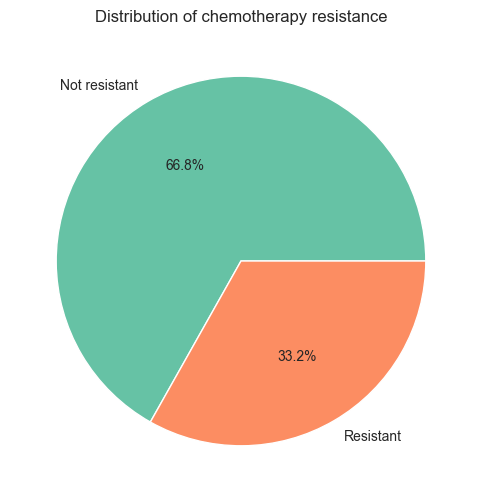

In [172]:
# Visualize the distribution of chemotherapy resistance 

# get counts of values for each of the categories from chemoresistance df
resistance_counts = chemoresistance_df["Chemotherapy_Resistance"].value_counts()

# create figure and plot the piechart
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(resistance_counts, labels=["Not resistant", "Resistant"], autopct="%1.1f%%", colors=sns.color_palette("Set2"))
plt.title("Distribution of chemotherapy resistance")
plt.show()

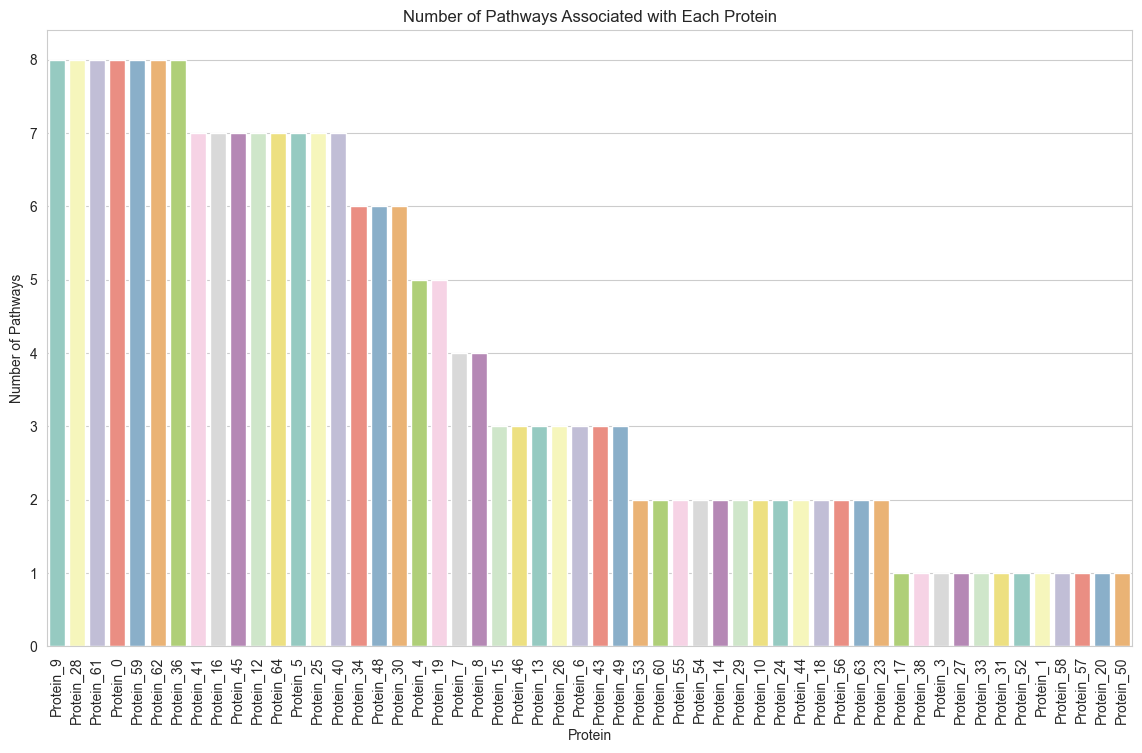

In [188]:
# Count the number of pathways associated with each protein
protein_counts = pathways_df["Protein"].value_counts()

# Bar chart for protein counts
plt.figure(figsize=(14,8))
sns.barplot(x=protein_counts.index, hue=protein_counts.index, y=protein_counts.values, palette="Set3")
plt.title("Number of Pathways Associated with Each Protein")
plt.xlabel("Protein")
plt.ylabel("Number of Pathways")
plt.xticks(rotation=90)
plt.show()

### Part 2: Data Preparation

### Part 3: Multi-Head Attention Network

### Part 4: Simple Neural Network

### Part 5: Evaluation of results